In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

from PIL import Image
import pickle


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')


In [3]:
num_cpus = tf.config.experimental.list_physical_devices('CPU')
print(num_cpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.00392157, 0.00392157, 0.00392157],
        [0.00688275, 0.00688275, 0.00688275],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.00110044, 0.00110044, 0.00110044],
        [0.8433974 , 0.8433974 , 0.8433974 ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.07869142, 0.07869142, 0.07869142],
        [0.4658467 , 0.4658467 , 0.4658467 ],
        [0.01734694, 0.01734694, 0.01734694],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0. 

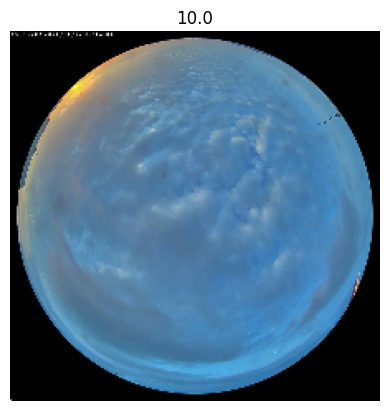

In [5]:


#for element in tf_data.map(process_img_label).take(1):
#   print(element)
"""
file_path = list(tf_data)[100]
image, label = process_img_label(file_path)

def show(image, label):
  plt.figure()
  print(image.shape)
  print(image)
  plt.imshow(image)
  plt.title(label.numpy())
  plt.axis('off')

show(image, label)
"""



**Data Preprocessing and Label Normalization for Sky Camera Image Dataset**

In [3]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
import joblib

# Create the MinMaxScaler object for target normalization
target_scaler = MinMaxScaler()

# Define paths to training and validation datasets
train_dataset = tf.data.Dataset.list_files("skycamera_images - Copie/*/*")
val_dataset = tf.data.Dataset.list_files("Val_set_folder/images/*/*")

# Define the total number of samples in the training and validation datasets
len_train = 211000
train_per = 0.5
len_val = 36000
val_per = 0.5

# Calculate the sizes of the training and validation datasets
train_size = int(len_train * train_per)
val_size = int(len_val * val_per)

# Assign datasets to train_ds and val_ds
train_ds = train_dataset
val_ds = val_dataset

# Function to get the label file path for training data
def get_label_train(filepath, labels_folder_path):
    time = tf.strings.split(filepath, sep="\\")[2]
    label_path = tf.strings.join([labels_folder_path, tf.strings.split(filepath, sep="\\")[1], tf.strings.split(time, sep=".")[0] + tf.constant(".txt")], separator="\\")
    return label_path

# Function to get the label file path for validation data
def get_label_val(filepath, labels_folder_path):
    time = tf.strings.split(filepath, sep="\\")[3]
    label_path = tf.strings.join([labels_folder_path, tf.strings.split(filepath, sep="\\")[2], tf.strings.split(time, sep=".")[0] + tf.constant(".txt")], separator="\\")
    return label_path

# Function to process image and label for validation data
def process_img_label_val(filepath, labels_folder_path):
    label_path = get_label_val(filepath, labels_folder_path)
    label = tf.io.read_file(label_path)
    label = tf.strings.to_number(label)
    label = normalize_label(label)
    
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = img / 255
    img = tf.image.resize(img, [128, 128])  # Scale and resize the image
    
    return img, label

# Function to process image and label for training data
def process_img_label_train(filepath, labels_folder_path):
    label_path = get_label_train(filepath, labels_folder_path)
    label = tf.io.read_file(label_path)
    label = tf.strings.to_number(label)
    label = normalize_label(label)
    
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = img / 255
    img = tf.image.resize(img, [128, 128])  # Scale and resize the image
    
    return img, label

# Function to normalize the label using Min-Max scaling
def normalize_label(label):
    label = tf.reshape(label, shape=(1, 1))  # Reshape to 2D array
    label = target_scaler.transform(label)  # Normalize the target value
    label = tf.squeeze(label)  # Remove extra dimensions
    return label

# Read and normalize labels for training data
train_labels = [tf.strings.to_number(tf.io.read_file(get_label_train(filepath, "labels_new"))) for filepath in train_dataset]
train_labels = tf.concat(train_labels, axis=0)
train_labels = tf.reshape(train_labels, shape=(-1, 1))  # Reshape to 2D array
train_labels = target_scaler.fit_transform(train_labels)  # Normalize the target values
train_labels = tf.squeeze(train_labels)

# Save the target scaler to a file
joblib.dump(target_scaler, 't_scaler.pkl')

**Displaying a training irradiance day**

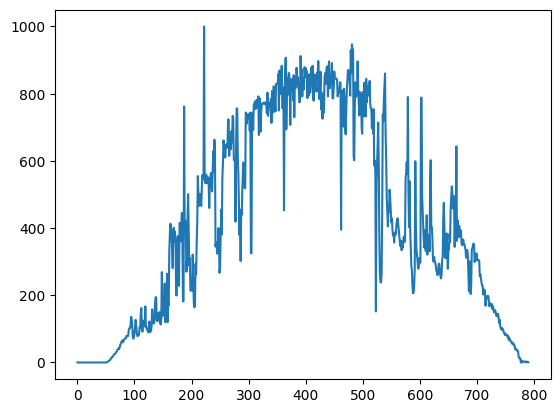

In [57]:
train=[]
for img in os.listdir("skycamera_images - Copie\\2021-07-03"):
    train_labels = tf.strings.to_number(tf.io.read_file(get_label_train(os.path.join("skycamera_images - Copie","2021-07-03",img),"labels_new"))).numpy()
    train+=[train_labels]

plt.plot(train)

**Displaying a sky image from validation set with its corresponding irradiance value**

(128, 128, 3)
tf.Tensor(
[[[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.26666668 0.26666668 0.26666668]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.65000004 0.65000004 0.65000004]
  [0.02647059 0.02647059 0.02647059]
  [0.87352943 0.87352943 0.87352943]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.       

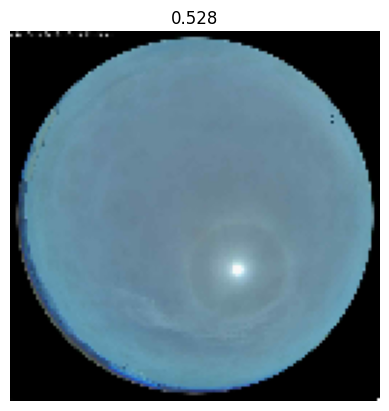

In [7]:
file_path = list(val_ds)[105]
image, label = process_img_label_val(file_path,os.path.join("Val_set_folder","labels"))

def show(image, label):
  plt.figure()
  print(image.shape)
  print(image)
  plt.imshow(image)
  plt.title(label.numpy())
  plt.axis('off')

show(image, label)

**Adding Data augmantation steps in our data pipeline because the models before were poor and need more data to be trained on**

In [ ]:
train_dataset_1=tf.data.Dataset.list_files("skycamera_images - Copie\\*\\*")
train_dataset_1=train_dataset_1.map(lambda x: process_img_label_train(x,"labels_new"), num_parallel_calls=tf.data.AUTOTUNE)

def augmant_1(img,lbl):
    img=tf.image.adjust_saturation(img, 0.1)
    return img,lbl

def augmant_2(img,lbl):
    k = tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32)
    # Apply random rotation
    img = tf.image.rot90(img, k)
    return img,lbl

train_test_dataset=train_dataset_1.map(lambda img,lbl:augmant_1(img,lbl))

In [5]:
train_dataset_1=tf.data.Dataset.list_files("skycamera_images - Copie\\*\\*")
train_dataset_1=train_dataset_1.map(lambda x: process_img_label_train(x,"labels_new"), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset_2=tf.data.Dataset.list_files("skycamera_images - Copie\\*\\*")
train_dataset_2=train_dataset_2.map(lambda x: process_img_label_train(x,"labels_new"), num_parallel_calls=tf.data.AUTOTUNE)

def augmant_1(img,lbl):
    img=tf.image.adjust_saturation(img, 0.1)
    return img,lbl

def augmant_2(img,lbl):
    k = tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32)
    # Apply random rotation
    img = tf.image.rot90(img, k)
    return img,lbl



**Data Augmentation and Combination of Training Datasets**

In [6]:
train_dataset_1=train_dataset_1.map(lambda img,lbl:augmant_1(img,lbl),num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
train_dataset_2=train_dataset_2.map(lambda img,lbl:augmant_2(img,lbl),num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1100)

train_dataset_0=tf.data.Dataset.list_files("skycamera_images - Copie/*/*")
train_dataset_0 = train_dataset.map(lambda x: process_img_label_train(x,"labels_new"), num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1200)

val_dataset=tf.data.Dataset.list_files("Val_set_folder/images/*/*")
comb_1=train_dataset_1.concatenate(train_dataset_2)
train_ds=comb_1.concatenate(train_dataset_0)
val_ds=val_dataset

In [ ]:
def augment_image(image, label):
    # Random rotation between -15 to 15 degrees
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

**Efficient Data Pipeline Configuration**

In [7]:
# Set the batch size for the training and validation datasets
batch_size = 128

# Cache the training dataset for faster access
train_ds = train_ds.cache('cacheee_folder')

# Shuffle and batch the training dataset
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size)

# Prefetch data to improve training performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# For the validation dataset, map the image processing function and set up caching, shuffling, batching, and prefetching
val_ds = val_ds.map(lambda x: process_img_label_val(x, os.path.join("Val_set_folder", "labels")), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.shuffle(buffer_size=1000)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


**Displaying augmanted data exemple**

(128, 128, 3)
tf.Tensor(
[[[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.26666668 0.26666668 0.26666668]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.65000004 0.65000004 0.65000004]
  [0.02647059 0.02647059 0.02647059]
  [0.87352943 0.87352943 0.87352943]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.       

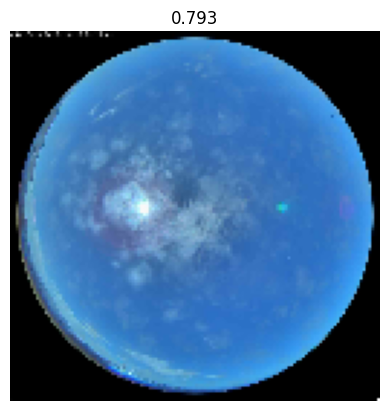

In [36]:

for element in train_ds.take(1):
  img=element[0][0]
  label=element[1][0]
  
def show(image, label):
  plt.figure()
  print(image.shape)
  print(image)
  plt.imshow(image)
  plt.title(label.numpy())
  plt.axis('off')

show(img, label)



In [59]:

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Input

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(64,64,3))

# Freeze the first 6 layers
#for layer in base_model.layers[:6]:
#    layer.trainable = False

# Add custom layers on top of the frozen layers
x = GlobalAveragePooling2D()(base_model.layers[-33].output)
#y = Flatten()(x)
z = Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
z = Dropout(0.3)(z)
w = Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))(z)
w = Dropout(0.3)(w)
final_output = Dense(1, activation='linear')(w)

# Create the modified model

model=tf.keras.Model(inputs=base_model.input,outputs=final_output)

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

**Training the resnet model on the augmanted data**

In [60]:
model=tf.keras.models.load_model("resnet_overfit.h5")
train_loss = []
val_loss = []
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 60, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)

# Training loop
num_epochs=700

model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,callbacks=my_callbacks,verbose=1)

Epoch 1/700
4946/4946 [==============================] - 3732s 752ms/step - loss: 6.2975 - mean_absolute_error: 0.0719 - val_loss: 0.1076 - val_mean_absolute_error: 0.0352
Epoch 2/700
4946/4946 [==============================] - 1163s 235ms/step - loss: 0.1309 - mean_absolute_error: 0.0633 - val_loss: 0.1021 - val_mean_absolute_error: 0.0379
Epoch 3/700
4946/4946 [==============================] - 1145s 231ms/step - loss: 0.1214 - mean_absolute_error: 0.0602 - val_loss: 0.0933 - val_mean_absolute_error: 0.0339
Epoch 4/700
4946/4946 [==============================] - 1167s 236ms/step - loss: 0.1159 - mean_absolute_error: 0.0582 - val_loss: 0.0971 - val_mean_absolute_error: 0.0407
Epoch 5/700
4946/4946 [==============================] - 1216s 246ms/step - loss: 0.1119 - mean_absolute_error: 0.0570 - val_loss: 0.0852 - val_mean_absolute_error: 0.0314
Epoch 6/700
4946/4946 [==============================] - 1156s 234ms/step - loss: 0.1090 - mean_absolute_error: 0.0562 - val_loss: 0.0850 - 

KeyboardInterrupt: 

In [61]:
model.save("resnet_augm_data.h5")

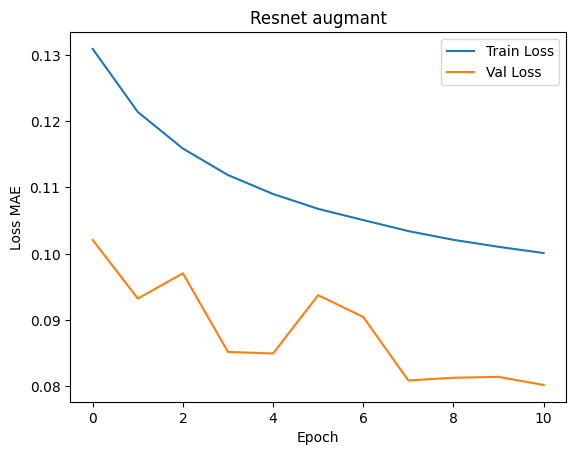

In [63]:
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

plt.plot(loss[1:], label='Train Loss')
plt.plot(val_loss[1:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend()
plt.title('Resnet augmant')
plt.show()